# MadMiner particle physics tutorial

# Part 3a: Training a likelihood ratio estimator

Johann Brehmer, Felix Kling, Irina Espejo, and Kyle Cranmer 2018-2019

In part 3a of this tutorial we will finally train a neural network to estimate likelihood ratios. We assume that you have run part 1 and 2a of this tutorial. If, instead of 2a, you have run part 2b, you just have to load a different filename later.

## Preparations

In [1]:
from __future__ import absolute_import, division, print_function, unicode_literals

import logging
import numpy as np
import matplotlib
from matplotlib import pyplot as plt
%matplotlib inline

from madminer.sampling import SampleAugmenter
from madminer import sampling
from madminer.ml import ParameterizedRatioEstimator


In [2]:
# MadMiner output
logging.basicConfig(
    format='%(asctime)-5.5s %(name)-20.20s %(levelname)-7.7s %(message)s',
    datefmt='%H:%M',
    level=logging.INFO
)

# Output of all other modules (e.g. matplotlib)
for key in logging.Logger.manager.loggerDict:
    if "madminer" not in key:
        logging.getLogger(key).setLevel(logging.WARNING)

## 1. Make (unweighted) training and test samples with augmented data

At this point, we have all the information we need from the simulations. But the data is not quite ready to be used for machine learning. The `madminer.sampling` class `SampleAugmenter` will take care of the remaining book-keeping steps before we can train our estimators:

First, it unweights the samples, i.e. for a given parameter vector `theta` (or a distribution `p(theta)`) it picks events `x` such that their distribution follows `p(x|theta)`. The selected samples will all come from the event file we have so far, but their frequency is changed -- some events will appear multiple times, some will disappear.

Second, `SampleAugmenter` calculates all the augmented data ("gold") that is the key to our new inference methods. Depending on the specific technique, these are the joint likelihood ratio and / or the joint score. It saves all these pieces of information for the selected events in a set of numpy files that can easily be used in any machine learning framework.

In [3]:
#sampler = SampleAugmenter('data/lhe_data_shuffled.h5')
sampler = SampleAugmenter('data/delphes_data_shuffled.h5')

19:08 madminer.analysis    INFO    Loading data from data/delphes_data_shuffled.h5
19:08 madminer.analysis    INFO    Found 1 parameters
19:08 madminer.analysis    INFO    Did not find nuisance parameters
19:08 madminer.analysis    INFO    Found 6 benchmarks, of which 6 physical
19:08 madminer.analysis    INFO    Found 35 observables
19:08 madminer.analysis    INFO    Found 3635115 events
19:08 madminer.analysis    INFO      856510 signal events sampled from benchmark no-higgs
19:08 madminer.analysis    INFO      821845 signal events sampled from benchmark 0.8_k
19:08 madminer.analysis    INFO      922750 signal events sampled from benchmark sm
19:08 madminer.analysis    INFO      112840 signal events sampled from benchmark 1.2_k
19:08 madminer.analysis    INFO      807988 signal events sampled from benchmark 1.5_k
19:08 madminer.analysis    INFO      113182 signal events sampled from benchmark 1.35_k
19:08 madminer.analysis    INFO    Found morphing setup with 5 components
19:08 madmi

The `SampleAugmenter` class defines five different high-level functions to generate train or test samples:
- `sample_train_plain()`, which only saves observations x, for instance for histograms or ABC;
- `sample_train_local()` for methods like SALLY and SALLINO, which will be demonstrated in the second part of the tutorial;
- `sample_train_density()` for neural density estimation techniques like MAF or SCANDAL;
- `sample_train_ratio()` for techniques like CARL, ROLR, CASCAL, and RASCAL, when only theta0 is parameterized;
- `sample_train_more_ratios()` for the same techniques, but with both theta0 and theta1 parameterized;
- `sample_test()` for the evaluation of any method.

For the arguments `theta`, `theta0`, or `theta1`, you can (and should!) use the helper functions `benchmark()`, `benchmarks()`, `morphing_point()`, `morphing_points()`, and `random_morphing_points()`, all defined in the `madminer.sampling` module.

Here we'll train a likelihood ratio estimator with the ALICES method, so we focus on the `extract_samples_train_ratio()` function. We'll sample the numerator hypothesis in the likelihood ratio with 1000 points drawn from a Gaussian prior, and fix the denominator hypothesis to the SM.

Note the keyword `sample_only_from_closest_benchmark=True`, which makes sure that for each parameter point we only use the events that were originally (in MG) generated from the closest benchmark. This reduces the statistical fluctuations in the outcome quite a bit.

In [4]:
x, theta0, theta1, y, r_xz, t_xz, n_effective = sampler.sample_train_ratio(
    theta0=sampling.random_morphing_points(100, [('flat', 0., 2.)]),
    theta1=sampling.benchmark('sm'),
    n_samples=10000000,
    folder='./data/samples',
    filename='train_ratioJB',
    sample_only_from_closest_benchmark=True,
    #sample_only_from_closest_benchmark=False,
    return_individual_n_effective=True,
)

19:08 madminer.sampling    INFO    Extracting training sample for ratio-based methods. Numerator hypothesis: 100 random morphing points, drawn from the following priors:
  theta_0 ~ flat from 0.0 to 2.0, denominator hypothesis: sm
19:08 madminer.sampling    INFO    Starting sampling serially
19:09 madminer.sampling    INFO    Sampling from parameter point 5 / 100
19:09 madminer.sampling    INFO    Sampling from parameter point 10 / 100
19:09 madminer.sampling    INFO    Sampling from parameter point 15 / 100
19:09 madminer.sampling    INFO    Sampling from parameter point 20 / 100
19:10 madminer.sampling    INFO    Sampling from parameter point 25 / 100
19:10 madminer.sampling    INFO    Sampling from parameter point 30 / 100
19:10 madminer.sampling    INFO    Sampling from parameter point 35 / 100
19:10 madminer.sampling    INFO    Sampling from parameter point 40 / 100
19:10 madminer.sampling    INFO    Sampling from parameter point 45 / 100
19:11 madminer.sampling    INFO    Samplin

Let's also make a validation sample:

For the evaluation we'll need a few test samples:

You might notice the information about the "effective number of samples" in the output. This is defined as `1 / max_events(weights)`; the smaller it is, the bigger the statistical fluctuations from too large weights. Let's plot this over the parameter space:

cut = (y.flatten()==0)

x_ = theta0[cut][:,0]
y_ = n_effective[cut]

order = np.argsort(x_)
y_ = y_[order]
x_ = x_[order]

fig = plt.figure(figsize=(5,5))

plt.plot(x_[x_<0.5], y_[x_<0.5], lw=1.5)
plt.plot(x_[(x_>0.5)*(x_<3)], y_[(x_>0.5)*(x_<3)], lw=1.5)
plt.plot(x_[x_>3.], y_[x_>3.], lw=1.5)

plt.xlabel("theta")
plt.ylabel('Effective number of samples')
plt.xlim(-0.2,2.2)
plt.ylim(0.,None)
#plt.yscale("log")

plt.tight_layout()
plt.savefig("effective_samplesize.pdf")


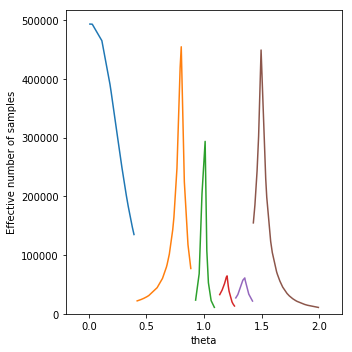

In [5]:
cut = (y.flatten()==0)

x_ = theta0[cut][:,0]
y_ = n_effective[cut]

order = np.argsort(x_)
y_ = y_[order]
x_ = x_[order]

fig = plt.figure(figsize=(5,5))

plt.plot(x_[x_<0.4], y_[x_<0.4], lw=1.5)
plt.plot(x_[(x_>0.4)*(x_<0.9)], y_[(x_>0.4)*(x_<0.9)], lw=1.5)
plt.plot(x_[(x_>0.9)*(x_<1.1)], y_[(x_>0.9)*(x_<1.1)], lw=1.5)
plt.plot(x_[(x_>1.1)*(x_<1.275)], y_[(x_>1.1)*(x_<1.275)], lw=1.5)
plt.plot(x_[(x_>1.275)*(x_<1.425)], y_[(x_>1.275)*(x_<1.425)], lw=1.5)
plt.plot(x_[x_>1.425], y_[x_>1.425], lw=1.5)

plt.xlabel("theta")
plt.ylabel('Effective number of samples')
plt.xlim(-0.2,2.2)
plt.ylim(0.,None)
#plt.yscale("log")

plt.tight_layout()
plt.savefig("effective_samplesize.pdf")



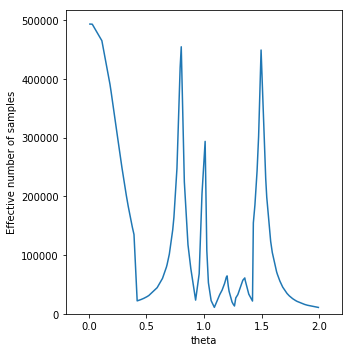

In [6]:
cut = (y.flatten()==0)

x_ = theta0[cut][:,0]
y_ = n_effective[cut]

order = np.argsort(x_)
y_ = y_[order]
x_ = x_[order]

fig = plt.figure(figsize=(5,5))
plt.plot(x_, y_, lw=1.5)
# plt.plot(x_[x_<0.4], y_[x_<0.4], lw=1.5)
# plt.plot(x_[(x_>0.4)*(x_<0.9)], y_[(x_>0.4)*(x_<0.9)], lw=1.5)
# plt.plot(x_[(x_>0.9)*(x_<1.25)], y_[(x_>0.9)*(x_<1.25)], lw=1.5)
# plt.plot(x_[x_>1.25], y_[x_>1.25], lw=1.5)

plt.xlabel("theta")
plt.ylabel('Effective number of samples')
plt.xlim(-0.2,2.2)
plt.ylim(0.,None)
#plt.yscale("log")

plt.tight_layout()
#plt.savefig("effective_samplesize.pdf")




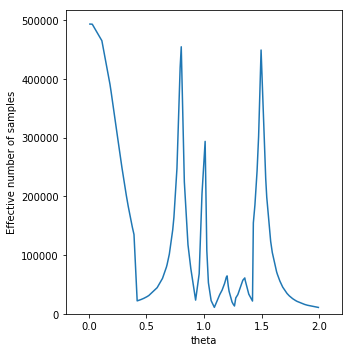

In [7]:
cut = (y.flatten()==0)

x_ = theta0[cut][:,0]
y_ = n_effective[cut]

order = np.argsort(x_)
y_ = y_[order]
x_ = x_[order]

fig = plt.figure(figsize=(5,5))
plt.plot(x_, y_, lw=1.5)
# plt.plot(x_[x_<0.4], y_[x_<0.4], lw=1.5)
# plt.plot(x_[(x_>0.4)*(x_<0.9)], y_[(x_>0.4)*(x_<0.9)], lw=1.5)
# plt.plot(x_[(x_>0.9)*(x_<1.25)], y_[(x_>0.9)*(x_<1.25)], lw=1.5)
# plt.plot(x_[x_>1.25], y_[x_>1.25], lw=1.5)

plt.xlabel("theta")
plt.ylabel('Effective number of samples')
plt.xlim(-0.2,2.2)
plt.ylim(0.,None)
#plt.yscale("log")

plt.tight_layout()
#plt.savefig("effective_samplesize.pdf")





## 2. Plot cross section over parameter space

This is not strictly necessary, but we can also plot the cross section as a function of parameter space:

In [8]:
thetas_benchmarks, xsecs_benchmarks, xsec_errors_benchmarks = sampler.cross_sections(
    theta=sampling.benchmarks(list(sampler.benchmarks.keys()))
)

thetas_morphing, xsecs_morphing, xsec_errors_morphing = sampler.cross_sections(
    theta=sampling.random_morphing_points(100, [('flat', 0., 2.5)])
)

19:16 madminer.sampling    INFO    Starting cross-section calculation
19:16 madminer.sampling    INFO    Starting cross-section calculation


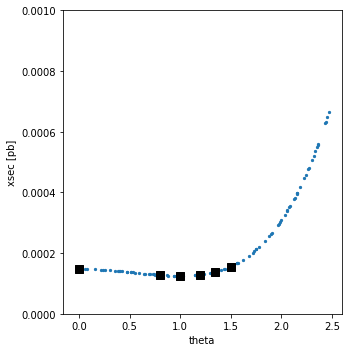

In [9]:
fig = plt.figure(figsize=(5,5))

sc = plt.scatter(thetas_morphing[:,0], xsecs_morphing, s=5., marker='o')

plt.scatter(thetas_benchmarks[:,0], xsecs_benchmarks, s=50., marker='s', c="black")

plt.xlabel("theta")
plt.ylabel('xsec [pb]')

#plt.ylim(0., None)
plt.ylim(0., 0.001)
plt.tight_layout()
plt.savefig("xsec.pdf")


What  you see here is a morphing algorithm in action. We only asked MadGraph to calculate event weights (differential cross sections, or basically squared matrix elements) at six fixed parameter points (shown here as squares with black edges). But with our knowledge about the structure of the process we can interpolate any observable to any parameter point without loss (except that statistical uncertainties might increase)!

## 3. Train likelihood ratio estimator

It's now time to build the neural network that estimates the likelihood ratio. The central object for this is the `madminer.ml.ParameterizedRatioEstimator` class. It defines functions that train, save, load, and evaluate the estimators.

In the initialization, the keywords `n_hidden` and `activation` define the architecture of the (fully connected) neural network:

In [ ]:
estimator = ParameterizedRatioEstimator(
    n_hidden=(100,100,),
    activation="tanh",
    dropout_prob=0.2,
)

To train this model we will minimize the ALICES loss function described in ["Likelihood-free inference with an improved cross-entropy estimator"](https://arxiv.org/abs/1808.00973). Many alternatives, including RASCAL, are described in ["Constraining Effective Field Theories With Machine Learning"](https://arxiv.org/abs/1805.00013) and ["A Guide to Constraining Effective Field Theories With Machine Learning"](https://arxiv.org/abs/1805.00020). There is also SCANDAL introduced in ["Mining gold from implicit models to improve likelihood-free inference"](https://arxiv.org/abs/1805.12244).

In [ ]:
estimator.train(
    method='alices',
    theta='data/samples/theta0_train_ratio.npy',
    x='data/samples/x_train_ratio.npy',
    y='data/samples/y_train_ratio.npy',
    r_xz='data/samples/r_xz_train_ratio.npy',
    t_xz='data/samples/t_xz_train_ratio.npy',
    theta_val='data/samples/theta0_val_ratio.npy',
    x_val='data/samples/x_val_ratio.npy',
    y_val='data/samples/y_val_ratio.npy',
    r_xz_val='data/samples/r_xz_val_ratio.npy',
    t_xz_val='data/samples/t_xz_val_ratio.npy',
    alpha=1.,
    n_epochs=5,
    batch_size=512,
    n_workers=4,
)

estimator.save('models/alices')

## 4. Evaluate likelihood ratio estimator

`estimator.evaluate_log_likelihood_ratio(theta,x)` estimated the log likelihood ratio and the score for all combination between the given phase-space points `x` and parameters `theta`. That is, if given 100 events `x` and a grid of 25 `theta` points, it will return 25\*100 estimates for the log likelihood ratio and 25\*100 estimates for the score, both indexed by `[i_theta,i_x]`.

In [ ]:
theta_each = np.linspace(-20.,20.,21)
theta0, theta1 = np.meshgrid(theta_each, theta_each)
theta_grid = np.vstack((theta0.flatten(), theta1.flatten())).T
np.save('data/samples/theta_grid.npy', theta_grid)

theta_denom = np.array([[0.,0.]])
np.save('data/samples/theta_ref.npy', theta_denom)


In [ ]:
estimator.load('models/alices')

log_r_hat, _ = estimator.evaluate_log_likelihood_ratio(
    theta='data/samples/theta_grid.npy',
    x='data/samples/x_test.npy',
    evaluate_score=False
)

Let's look at the result:

In [ ]:
bin_size = theta_each[1] - theta_each[0]
edges = np.linspace(theta_each[0] - bin_size/2, theta_each[-1] + bin_size/2, len(theta_each)+1)

fig = plt.figure(figsize=(6,5))
ax = plt.gca()

expected_llr = np.mean(log_r_hat,axis=1)
best_fit = theta_grid[np.argmin(-2.*expected_llr)]

cmin, cmax = np.min(-2*expected_llr), np.max(-2*expected_llr)
    
pcm = ax.pcolormesh(edges, edges, -2. * expected_llr.reshape((21,21)),
                    norm=matplotlib.colors.Normalize(vmin=cmin, vmax=cmax),
                    cmap='viridis_r')
cbar = fig.colorbar(pcm, ax=ax, extend='both')

plt.scatter(best_fit[0], best_fit[1], s=80., color='black', marker='*')

plt.xlabel(r'$\theta_0$')
plt.ylabel(r'$\theta_1$')
cbar.set_label(r'$\mathbb{E}_x [ -2\, \log \,\hat{r}(x | \theta, \theta_{SM}) ]$')

plt.tight_layout()
plt.show()


Note that in this tutorial our sample size was very small, and the network might not really have a chance to converge to the correct likelihood ratio function. So don't worry if you find a minimum that is not at the right point (the SM, i.e. the origin in this plot). Feel free to dial up the event numbers in the run card as well as the training samples and see what happens then!